# Importing Libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,InputLayer, Dropout,GlobalAveragePooling2D, Flatten,Conv2D,MaxPooling2D,BatchNormalization,Layer,Input,Rescaling
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import SparseCategoricalAccuracy,SparseTopKCategoricalAccuracy
from tensorflow.keras.layers import (Dense,Permute,InputLayer, Dropout, Flatten,Conv2D,MaxPooling2D,BatchNormalization,Layer,
                                     Input, RandomRotation,RandomFlip, Resizing,Rescaling)
from tensorflow.keras.metrics import  BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard,CSVLogger, EarlyStopping, LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
import sklearn
import seaborn as sns
import cv2
import imghdr
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D,MaxPooling2D,BatchNormalization,InputLayer
from keras.models import Model
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, Xception, InceptionResNetV2, MobileNet
# from classification_models.tfkeras import Classifiers
from sklearn.utils import class_weight
import numpy as np
import pandas as pd

#  Data Loading

In [4]:
data_dir_train="/kaggle/input/skindiseasedataset/SkinDisease/train"
data_dir_test="/kaggle/input/skindiseasedataset/SkinDisease/test"

In [6]:
train_data=tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
)

Found 13898 files belonging to 22 classes.


In [7]:
class_names = train_data.class_names
class_names

['Acne',
 'Actinic_Keratosis',
 'Benign_tumors',
 'Bullous',
 'Candidiasis',
 'DrugEruption',
 'Eczema',
 'Infestations_Bites',
 'Lichen',
 'Lupus',
 'Moles',
 'Psoriasis',
 'Rosacea',
 'Seborrh_Keratoses',
 'SkinCancer',
 'Sun_Sunlight_Damage',
 'Tinea',
 'Unknown_Normal',
 'Vascular_Tumors',
 'Vasculitis',
 'Vitiligo',
 'Warts']

In [8]:
test_data=tf.keras.utils.image_dataset_from_directory(data_dir_test)

Found 1546 files belonging to 22 classes.


###  Batch data

In [9]:
train_data_itr=train_data.as_numpy_iterator()
batch=train_data_itr.next()
print(len(batch))
print(batch[0].shape)
print(batch[1])

2
(32, 256, 256, 3)
[ 1  2  1 15  2 11  2 20 21  4  5  2 11 21  9 17  2 11 14 11  7 11 20 20
 14 21  2 17  2 20 16 16]


# Data Visualization

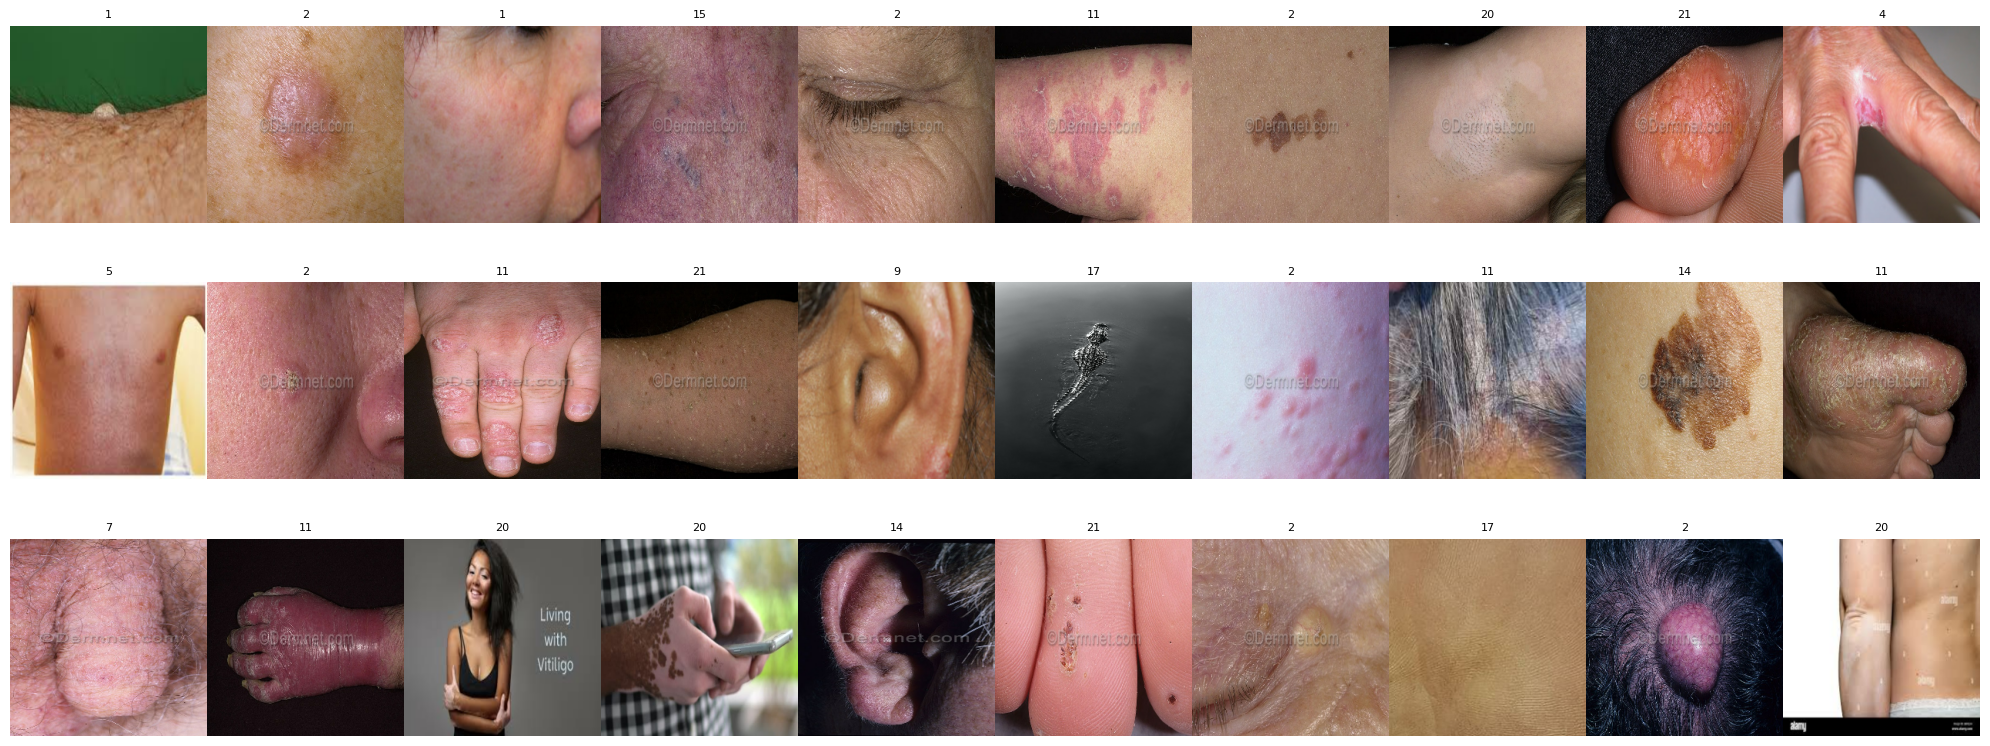

In [10]:
# Create figure and axes for 3 rows and 10 columns
fig, ax = plt.subplots(nrows=3, ncols=10, figsize=(20, 8))
# Plot each image in the grid and add a title
for idx, img in enumerate(batch[0][:30]):
    row = idx // 10
    col = idx % 10
    ax[row, col].imshow(img.astype(int))
    ax[row, col].set_title(str(batch[1][idx]), fontsize=8)
    ax[row, col].axis('off')  # Turn off axes for a cleaner look

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)  # Adjust space between images
plt.show()

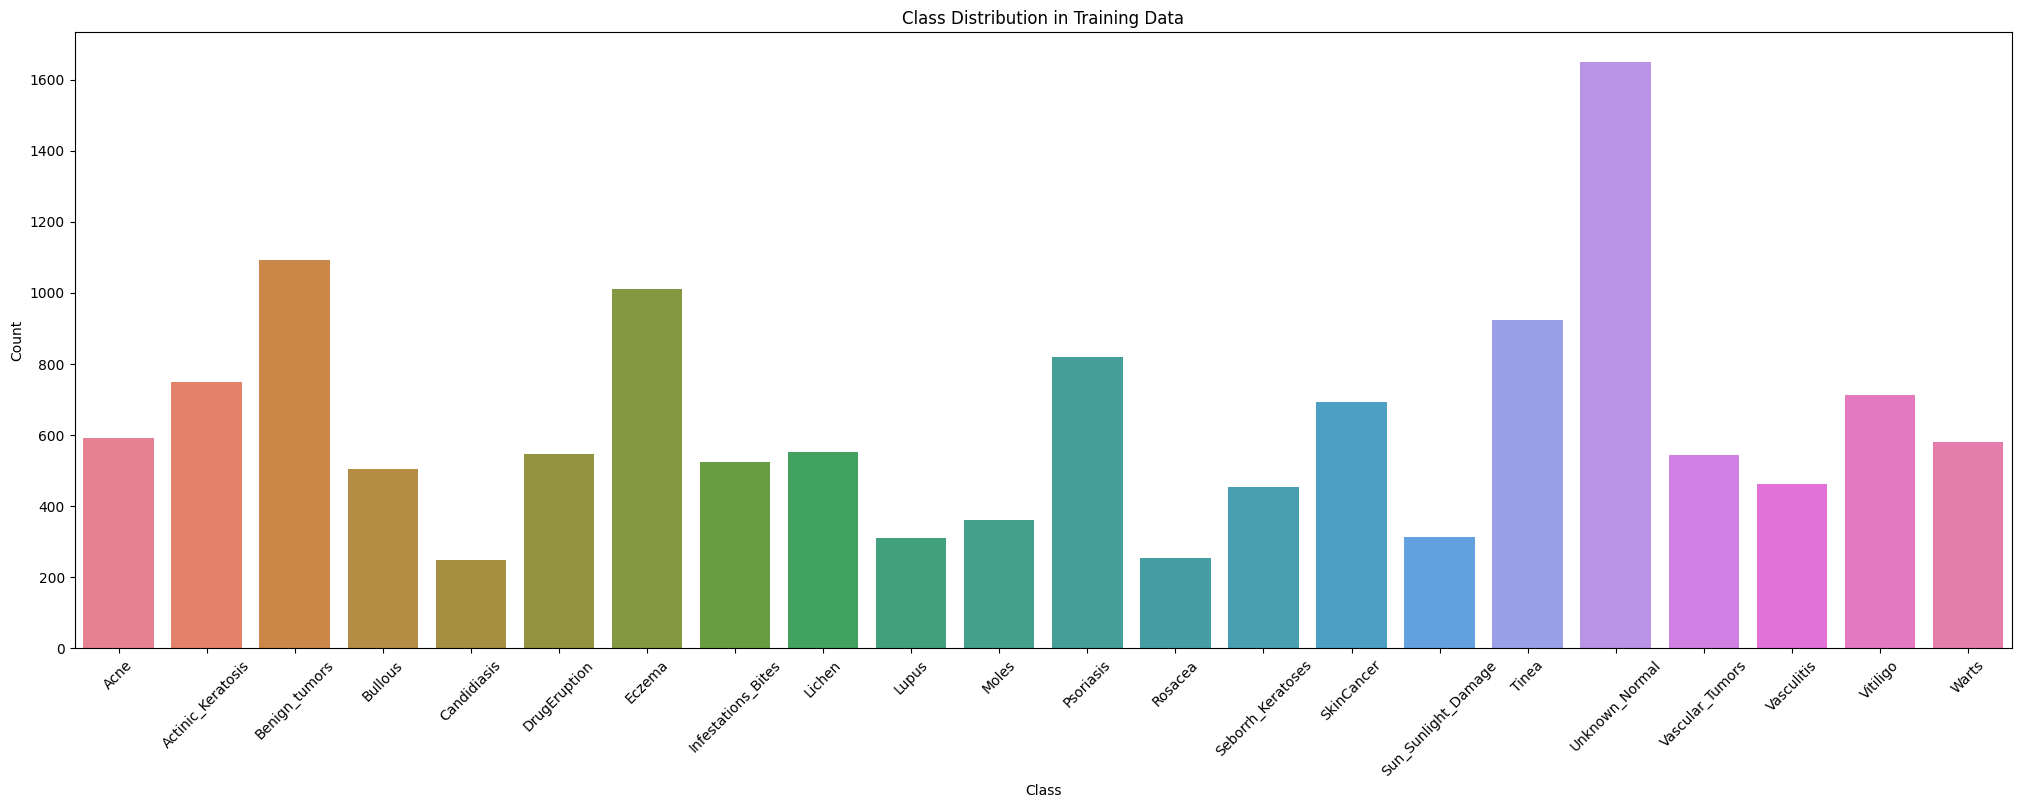

In [18]:
class_names = train_data.class_names
class_counts = np.zeros(len(class_names))

# Iterate over train_data to count instances of each class
for _, labels in train_data:
    for label in labels:
        class_counts[label] += 1

# Plotting the class distribution
plt.figure(figsize=(25, 8))
# plt.bar(class_names, class_counts, color='skyblue')
sns.barplot(x=class_names, y=class_counts,hue=class_names,legend=False)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()

# Data Prepration

In [11]:
train_dataset=(
    train_data.prefetch(tf.data.AUTOTUNE)
)
val_dataset=(
    test_data.prefetch(tf.data.AUTOTUNE)
)

### Handeling Class Imbalance

In [19]:
y_train = np.concatenate([y for x, y in train_data], axis=0)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Model Training

## Tpu Configuration

In [20]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategya
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

### metrics

In [115]:
with tpu_strategy.scope():
    metrics=[ SparseCategoricalAccuracy( name ="accuracy"), SparseTopKCategoricalAccuracy(k=2, name="top_2_accuracy")]

In [32]:
# Dictionaries to store  metrics for each model
accuracy_dict = {
    'VGG16' :[],
    'ResNet50': [],
    'SEResNet':[],
    'InceptionV3': [],
    'Xception': [],
    'InceptionResNetV2': [],
    'MobileNet': [],
    'EfficientNet':[],
    'ViT':[]
}

top_2_accuracy_dict = {
    'VGG16' :[],
    'ResNet50': [],
    'SEResNet':[],
    'InceptionV3': [],
    'Xception': [],
    'InceptionResNetV2': [],
    'MobileNet': [],
    'EfficientNet':[],
    'ViT':[]
}

loss_dict = {
    'VGG16' :[],
    'ResNet50': [],
    'SEResNet':[],
    'InceptionV3': [],
    'Xception': [],
    'InceptionResNetV2': [],
    'MobileNet': [],
    'EfficientNet':[],
    'ViT':[]
}


## VGG16 Model

In [47]:
# Define the VGG model
def create_vgg_model(num_classes=23):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    x = layers.GlobalAveragePooling2D()(base_model.output)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



In [48]:
with tpu_strategy.scope():
    vgg_model = create_vgg_model()
    vgg_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [53]:
with tpu_strategy.scope():
    vgg_model.compile(Adam(learning_rate=1e-5), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=[metrics])

In [54]:
 vgg16_history = vgg_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20,
        class_weight=class_weights_dict, 
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
    )
    
accuracy_dict['VGG16'].extend(vgg16_history.history['val_accuracy'])
top_2_accuracy_dict['VGG16'].extend(vgg16_history.history['val_top_2_accuracy'])
loss_dict['VGG16'].extend(vgg16_history.history['val_loss'])

Epoch 1/20


2024-10-30 19:28:14.383868: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


435/435 [==============================] - 27s 50ms/step - loss: 0.0315 - accuracy: 0.9539 - top_2_accuracy: 0.9713 - val_loss: 2.8138 - val_accuracy: 0.6177 - val_top_2_accuracy: 0.7523
Epoch 2/20
435/435 [==============================] - 20s 47ms/step - loss: 0.0217 - accuracy: 0.9956 - top_2_accuracy: 0.9998 - val_loss: 2.9177 - val_accuracy: 0.6184 - val_top_2_accuracy: 0.7361
Epoch 3/20
435/435 [==============================] - 21s 48ms/step - loss: 0.0179 - accuracy: 0.9961 - top_2_accuracy: 1.0000 - val_loss: 2.8922 - val_accuracy: 0.6235 - val_top_2_accuracy: 0.7471
Epoch 4/20
435/435 [==============================] - 21s 48ms/step - loss: 0.0174 - accuracy: 0.9959 - top_2_accuracy: 0.9999 - val_loss: 2.8691 - val_accuracy: 0.6177 - val_top_2_accuracy: 0.7387
Epoch 5/20
435/435 [==============================] - 21s 47ms/step - loss: 0.0142 - accuracy: 0.9963 - top_2_accuracy: 0.9999 - val_loss: 2.9131 - val_accuracy: 0.6184 - val_top_2_accuracy: 0.7419
Epoch 6/20
435/435 [=

## Resnet50 Model

In [58]:
# Define the ResNet model
def create_resnet_model(num_classes=23):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [59]:
with tpu_strategy.scope():
    resnet_model = create_vgg_model()
    resnet_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [69]:
with tpu_strategy.scope():
    resnet_model.compile(Adam(learning_rate=1e-5), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=[metrics])

In [70]:
 resnet_history = resnet_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20,
        class_weight=class_weights_dict,  
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
    )
accuracy_dict['ResNet50'].extend(resnet_history.history['val_accuracy'])
top_2_accuracy_dict['ResNet50'].extend(resnet_history.history['val_top_2_accuracy'])
loss_dict['ResNet50'].extend(resnet_history.history['val_loss'])

Epoch 1/20


2024-10-30 19:50:29.594716: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


435/435 [==============================] - 26s 49ms/step - loss: 0.0393 - accuracy: 0.9474 - top_2_accuracy: 0.9697 - val_loss: 3.0548 - val_accuracy: 0.6041 - val_top_2_accuracy: 0.7251
Epoch 2/20
435/435 [==============================] - 21s 48ms/step - loss: 0.0197 - accuracy: 0.9958 - top_2_accuracy: 0.9998 - val_loss: 3.0941 - val_accuracy: 0.6138 - val_top_2_accuracy: 0.7270
Epoch 3/20
435/435 [==============================] - 21s 48ms/step - loss: 0.0191 - accuracy: 0.9960 - top_2_accuracy: 0.9996 - val_loss: 3.1554 - val_accuracy: 0.6132 - val_top_2_accuracy: 0.7264
Epoch 4/20
435/435 [==============================] - 21s 47ms/step - loss: 0.0151 - accuracy: 0.9961 - top_2_accuracy: 0.9998 - val_loss: 3.1937 - val_accuracy: 0.6132 - val_top_2_accuracy: 0.7180
Epoch 5/20
435/435 [==============================] - 22s 49ms/step - loss: 0.0155 - accuracy: 0.9964 - top_2_accuracy: 0.9996 - val_loss: 3.2051 - val_accuracy: 0.6087 - val_top_2_accuracy: 0.7212


## SEResnet Model

In [71]:
# Define a simplified SEResNet Block
def se_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)

    return layers.multiply([input_tensor, se])

# Define a simplified SEResNet50 model
def create_seresnet_model(input_shape=(256, 256, 3), num_classes=23):
    input_tensor = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Add SEResNet blocks (simplified)
    for _ in range(3):  # Simplified for example
        residual = x
        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = se_block(x)  # Apply SE block
        x = layers.add([x, residual])

    x = layers.GlobalAveragePooling2D()(x)
    output_tensor = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_tensor, outputs=output_tensor)
    return model


In [72]:
with tpu_strategy.scope():
    seresnet_model = create_seresnet_model()
    seresnet_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 256, 256, 64)         0         ['batch_normalization[0]

In [81]:
with tpu_strategy.scope():
    seresnet_model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=[metrics])

In [74]:
accuracy_dict['SEResNet']=[]
top_2_accuracy_dict['SEResNet']=[]
loss_dict['SEResNet']=[]

In [82]:
seresnet_history = seresnet_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20,
        class_weight=class_weights_dict,  
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
    )
accuracy_dict['SEResNet'].extend(seresnet_history.history['val_accuracy'])
top_2_accuracy_dict['SEResNet'].extend(seresnet_history.history['val_top_2_accuracy'])
loss_dict['SEResNet'].extend(seresnet_history.history['val_loss'])

Epoch 1/20


2024-10-30 19:59:11.747840: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


435/435 [==============================] - 47s 95ms/step - loss: nan - accuracy: 0.0426 - top_2_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0420 - val_top_2_accuracy: 0.0000e+00
Epoch 2/20
435/435 [==============================] - 40s 92ms/step - loss: nan - accuracy: 0.0427 - top_2_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0420 - val_top_2_accuracy: 0.0000e+00
Epoch 3/20
435/435 [==============================] - 40s 91ms/step - loss: nan - accuracy: 0.0427 - top_2_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0420 - val_top_2_accuracy: 0.0000e+00
Epoch 4/20
435/435 [==============================] - 40s 92ms/step - loss: nan - accuracy: 0.0427 - top_2_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0420 - val_top_2_accuracy: 0.0000e+00


## Inceptionv3 Model

In [83]:
def create_inceptionv3_model(num_classes=23):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [84]:
with tpu_strategy.scope():
    inceptionv3_model = create_inceptionv3_model()
    inceptionv3_model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 127, 127, 32)         864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_7 (Bat  (None, 127, 127, 32)         96        ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)   

In [89]:
with tpu_strategy.scope():
    inceptionv3_model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=[metrics])

In [90]:
inceptionv3_history = inceptionv3_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20,
        class_weight=class_weights_dict,  
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
    )
accuracy_dict['InceptionV3'].extend(inceptionv3_history.history['val_accuracy'])
top_2_accuracy_dict['InceptionV3'].extend(inceptionv3_history.history['val_top_2_accuracy'])
loss_dict['InceptionV3'].extend(inceptionv3_history.history['val_loss'])

Epoch 1/20


2024-10-30 20:20:52.394848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


435/435 [==============================] - 69s 100ms/step - loss: 0.0883 - accuracy: 0.9389 - top_2_accuracy: 0.9678 - val_loss: 1.9066 - val_accuracy: 0.6688 - val_top_2_accuracy: 0.7775
Epoch 2/20
435/435 [==============================] - 39s 90ms/step - loss: 0.0749 - accuracy: 0.9783 - top_2_accuracy: 0.9924 - val_loss: 1.8985 - val_accuracy: 0.6701 - val_top_2_accuracy: 0.7775
Epoch 3/20
435/435 [==============================] - 40s 91ms/step - loss: 0.0654 - accuracy: 0.9799 - top_2_accuracy: 0.9942 - val_loss: 1.8948 - val_accuracy: 0.6656 - val_top_2_accuracy: 0.7827
Epoch 4/20
435/435 [==============================] - 39s 90ms/step - loss: 0.0588 - accuracy: 0.9832 - top_2_accuracy: 0.9946 - val_loss: 1.8822 - val_accuracy: 0.6734 - val_top_2_accuracy: 0.7833
Epoch 5/20
435/435 [==============================] - 39s 90ms/step - loss: 0.0586 - accuracy: 0.9822 - top_2_accuracy: 0.9947 - val_loss: 1.8844 - val_accuracy: 0.6630 - val_top_2_accuracy: 0.7814
Epoch 6/20
435/435 [

## Xception Model

In [91]:
# Define the Xception model
def create_xception_model(num_classes=23):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [92]:
with tpu_strategy.scope():
    xception_model = create_xception_model()
    xception_model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 127, 127, 32)         864       ['input_7[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 127, 127, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati

In [97]:
with tpu_strategy.scope():
    xception_model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=[metrics])

In [98]:
xception_history = xception_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20,
        class_weight=class_weights_dict,  
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
    )
accuracy_dict['Xception'].extend(xception_history.history['val_accuracy'])
top_2_accuracy_dict['Xception'].extend(xception_history.history['val_top_2_accuracy'])
loss_dict['Xception'].extend(xception_history.history['val_loss'])

Epoch 1/20


2024-10-30 20:36:06.923162: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


435/435 [==============================] - 58s 87ms/step - loss: nan - accuracy: 0.0426 - top_2_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0420 - val_top_2_accuracy: 0.0000e+00
Epoch 2/20
435/435 [==============================] - 36s 81ms/step - loss: nan - accuracy: 0.0427 - top_2_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0420 - val_top_2_accuracy: 0.0000e+00
Epoch 3/20
435/435 [==============================] - 36s 82ms/step - loss: nan - accuracy: 0.0427 - top_2_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0420 - val_top_2_accuracy: 0.0000e+00
Epoch 4/20
435/435 [==============================] - 36s 82ms/step - loss: nan - accuracy: 0.0427 - top_2_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0420 - val_top_2_accuracy: 0.0000e+00


## InceptionResNetV2 Model

In [99]:
# Define the InceptionResNetV2 model
def create_inceptionresnetv2_model(num_classes=23):
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [100]:
with tpu_strategy.scope():
    inceptionresnetv2_model = create_inceptionresnetv2_model()
    inceptionresnetv2_model.summary()

219055592/219055592 [==============================] - 1s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_105 (Conv2D)         (None, 127, 127, 32)         864       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_105 (B  (None, 127, 127, 32)         96        ['conv2d_105[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_94 (Activatio

In [103]:
with tpu_strategy.scope():
    inceptionresnetv2_model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=[metrics])

In [104]:
inceptionresnetv2_history = inceptionresnetv2_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20,
        class_weight=class_weights_dict,  
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
    )
accuracy_dict['InceptionResNetV2'].extend(inceptionresnetv2_history.history['val_accuracy'])
top_2_accuracy_dict['InceptionResNetV2'].extend(inceptionresnetv2_history.history['val_top_2_accuracy'])
loss_dict['InceptionResNetV2'].extend(inceptionresnetv2_history.history['val_loss'])

Epoch 1/20


2024-10-30 21:02:44.596565: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


435/435 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9251 - top_2_accuracy: 0.9622

2024-10-30 21:04:16.900621: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


435/435 [==============================] - 156s 206ms/step - loss: 0.1254 - accuracy: 0.9251 - top_2_accuracy: 0.9622 - val_loss: 1.9355 - val_accuracy: 0.6539 - val_top_2_accuracy: 0.7658
Epoch 2/20
435/435 [==============================] - 83s 191ms/step - loss: 0.0834 - accuracy: 0.9752 - top_2_accuracy: 0.9930 - val_loss: 2.0111 - val_accuracy: 0.6604 - val_top_2_accuracy: 0.7633
Epoch 3/20
435/435 [==============================] - 82s 188ms/step - loss: 0.0729 - accuracy: 0.9788 - top_2_accuracy: 0.9939 - val_loss: 2.0680 - val_accuracy: 0.6598 - val_top_2_accuracy: 0.7600
Epoch 4/20
435/435 [==============================] - 83s 190ms/step - loss: 0.0600 - accuracy: 0.9817 - top_2_accuracy: 0.9955 - val_loss: 2.0377 - val_accuracy: 0.6488 - val_top_2_accuracy: 0.7633
Epoch 5/20
435/435 [==============================] - 83s 190ms/step - loss: 0.0522 - accuracy: 0.9850 - top_2_accuracy: 0.9962 - val_loss: 2.0723 - val_accuracy: 0.6611 - val_top_2_accuracy: 0.7710
Epoch 6/20
435/

## MobileNet Model

In [105]:
# Define the MobileNet model
def create_mobilenet_model(num_classes=23):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [106]:
with tpu_strategy.scope():
    mobilenet_model = create_mobilenet_model()
    mobilenet_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 128, 128, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 128, 128, 32)      288       
 )                                                               
                                                            

In [110]:
with tpu_strategy.scope():
    mobilenet_model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=[metrics])

In [111]:
mobilenet_history = mobilenet_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20,
        class_weight=class_weights_dict,  
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
    )
accuracy_dict['MobileNet'].extend(mobilenet_history.history['val_accuracy'])
top_2_accuracy_dict['MobileNet'].extend(mobilenet_history.history['val_top_2_accuracy'])
loss_dict['MobileNet'].extend(mobilenet_history.history['val_loss'])

Epoch 1/20


2024-10-30 21:22:20.007471: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


435/435 [==============================] - 35s 55ms/step - loss: nan - accuracy: 0.0426 - top_2_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0420 - val_top_2_accuracy: 0.0000e+00
Epoch 2/20
435/435 [==============================] - 23s 52ms/step - loss: nan - accuracy: 0.0427 - top_2_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0420 - val_top_2_accuracy: 0.0000e+00
Epoch 3/20
435/435 [==============================] - 23s 54ms/step - loss: nan - accuracy: 0.0427 - top_2_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0420 - val_top_2_accuracy: 0.0000e+00
Epoch 4/20
435/435 [==============================] - 22s 51ms/step - loss: nan - accuracy: 0.0427 - top_2_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0420 - val_top_2_accuracy: 0.0000e+00


## EfficientNet

In [127]:
with tpu_strategy.scope():
    backbone=tf.keras.applications.efficientnet_v2.EfficientNetV2L(
        include_top=False,
        weights='imagenet',
        input_shape=(256,256,3),
        include_preprocessing=True
    )

In [128]:
backbone.trainable=False

In [129]:
with tpu_strategy.scope():
    func_input=Input(shape=(256, 256, 3))
    x=backbone(func_input,)
    x=GlobalAveragePooling2D()(x)

    x=Dense(500,activation='relu')(x)
    x=BatchNormalization()(x)
    x=Dropout(0.3)(x)

    x= Dense(100,activation='relu')(x)
    x=BatchNormalization()(x)

    x=Dense(22,activation='softmax')(x)

    func_model=Model(func_input,x, name="func_model")
    func_model.summary()

Model: "func_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetv2-l (Function  (None, 8, 8, 1280)        117746848 
 al)                                                             
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 4 (GlobalAveragePooling2D)                                      
                                                                 
 dense_21 (Dense)            (None, 500)               640500    
                                                                 
 batch_normalization_312 (B  (None, 500)               2000      
 atchNormalization)                                              
                                                        

In [135]:
with tpu_strategy.scope():
    func_model.compile(Adam(learning_rate=0.00001), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=[metrics])

In [131]:
plateau_callback= ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='auto',
    min_delta=0.001,
    cooldown=0,
    min_lr=0,
 
)

In [132]:
accuracy_dict['EfficientNet']=[]
top_2_accuracy_dict['EfficientNet']=[]
loss_dict['EfficientNet']=[]

In [136]:
efficient_history=func_model.fit(train_dataset,epochs=10, validation_data=val_dataset,
                                 verbose=1,callbacks=[plateau_callback],class_weight=class_weights_dict)

accuracy_dict['EfficientNet'].extend(efficient_history.history['val_accuracy'])
top_2_accuracy_dict['EfficientNet'].extend(efficient_history.history['val_top_2_accuracy'])
loss_dict['EfficientNet'].extend(efficient_history.history['val_loss'])
# func_model.save('./my_model')

Epoch 1/10


2024-10-30 22:03:11.200598: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


435/435 [==============================] - ETA: 0s - loss: 1.8902 - accuracy: 0.4443 - top_2_accuracy: 0.5897

2024-10-30 22:04:50.460670: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


435/435 [==============================] - 171s 235ms/step - loss: 1.8902 - accuracy: 0.4443 - top_2_accuracy: 0.5897 - val_loss: 1.7430 - val_accuracy: 0.4722 - val_top_2_accuracy: 0.6358 - lr: 1.0000e-05
Epoch 2/10
435/435 [==============================] - 33s 76ms/step - loss: 1.8875 - accuracy: 0.4396 - top_2_accuracy: 0.5878 - val_loss: 1.7356 - val_accuracy: 0.4702 - val_top_2_accuracy: 0.6378 - lr: 1.0000e-05
Epoch 3/10
435/435 [==============================] - 34s 78ms/step - loss: 1.8782 - accuracy: 0.4424 - top_2_accuracy: 0.5861 - val_loss: 1.7345 - val_accuracy: 0.4683 - val_top_2_accuracy: 0.6429 - lr: 1.0000e-05
Epoch 4/10
435/435 [==============================] - 34s 79ms/step - loss: 1.8721 - accuracy: 0.4419 - top_2_accuracy: 0.5883 - val_loss: 1.7290 - val_accuracy: 0.4767 - val_top_2_accuracy: 0.6417 - lr: 1.0000e-05
Epoch 5/10
435/435 [==============================] - 33s 76ms/step - loss: 1.8704 - accuracy: 0.4428 - top_2_accuracy: 0.5918 - val_loss: 1.7241 - v

## ViT

In [137]:
resize_rescale_hf= tf.keras.Sequential([
    Resizing(224,224),
    Rescaling(1./225),
    Permute((3,1,2))
])

In [99]:
with tpu_strategy.scope():
    metrics=[ SparseCategoricalAccuracy( name ="accuracy"), SparseTopKCategoricalAccuracy(k=3, name="top_3_accuracy")]

In [138]:
with tpu_strategy.scope():
    from transformers import ViTFeatureExtractor, TFViTModel

    base_model=TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

    inputs=Input(shape=(256,256,3))

    x= resize_rescale_hf(inputs)
    x=base_model.vit(x)[0][:,0,:]
    outputs=Dense(23,activation="softmax")(x)
    hf_model=tf.keras.Model(inputs=inputs,outputs=outputs)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
config.json: 100%|██████████| 502/502 [00:00<00:00, 2.12MB/s]
model.safetensors: 100%|██████████| 346M/346M [00:01<00:00, 174MB/s]  
All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [148]:
with tpu_strategy.scope():
    hf_model.compile(Adam(learning_rate=1e-6), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=[metrics])
    hf_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPo   86389248  
                             oling(last_hidden_state             
                             =(None, 197, 768),                  
                              pooler_output=(None, 7             
                             68),                                
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0   

In [140]:
plateau_callback= ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=0.001,
    cooldown=0,
    min_lr=0,
 
)

In [142]:
accuracy_dict['ViT']=[]
top_2_accuracy_dict['ViT']=[]
loss_dict['ViT']=[]

In [149]:
vit_history=hf_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1,
#     callbacks=[plateau_callback]
    class_weight=class_weights_dict,

)
# val_accuracy can reach upto approx 78%-80% by increasing number of epochs and changing learning rate.
accuracy_dict['ViT'].extend(vit_history.history['val_accuracy'])
top_2_accuracy_dict['ViT'].extend(vit_history.history['val_top_2_accuracy'])
loss_dict['ViT'].extend(vit_history.history['val_loss'])

Epoch 1/10


2024-10-30 22:45:32.500772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


435/435 [==============================] - 98s 131ms/step - loss: 0.0042 - accuracy: 0.9751 - top_2_accuracy: 0.9874 - val_loss: 1.2717 - val_accuracy: 0.7762 - val_top_2_accuracy: 0.8797
Epoch 2/10
435/435 [==============================] - 53s 122ms/step - loss: 0.0042 - accuracy: 0.9975 - top_2_accuracy: 1.0000 - val_loss: 1.2702 - val_accuracy: 0.7807 - val_top_2_accuracy: 0.8790
Epoch 3/10
435/435 [==============================] - 53s 121ms/step - loss: 0.0042 - accuracy: 0.9974 - top_2_accuracy: 1.0000 - val_loss: 1.2691 - val_accuracy: 0.7801 - val_top_2_accuracy: 0.8797
Epoch 4/10
435/435 [==============================] - 54s 123ms/step - loss: 0.0042 - accuracy: 0.9974 - top_2_accuracy: 1.0000 - val_loss: 1.2704 - val_accuracy: 0.7807 - val_top_2_accuracy: 0.8797
Epoch 5/10
435/435 [==============================] - 53s 121ms/step - loss: 0.0041 - accuracy: 0.9974 - top_2_accuracy: 1.0000 - val_loss: 1.2704 - val_accuracy: 0.7820 - val_top_2_accuracy: 0.8784
Epoch 6/10
435/4

# Performance Comparison

In [161]:
def plot_metrics_seaborn(metrics_dict, title, ylabel):
    plt.figure(figsize=(17, 8))
    
    # Convert dictionary to DataFrame for easier plotting with Seaborn
    metrics_df = pd.DataFrame({model: pd.Series(values) for model, values in metrics_dict.items()})
    metrics_df['Epoch'] = metrics_df.index + 1  # Add Epoch column for x-axis

    # Melt the DataFrame to use with Seaborn
    metrics_melted = metrics_df.melt(id_vars='Epoch', var_name='Model', value_name=ylabel)
    
    # Plot with Seaborn
    sns.lineplot(data=metrics_melted, x='Epoch', y=ylabel, hue='Model', marker="o", palette="tab10")
    plt.title(f'{title} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()



## Loss

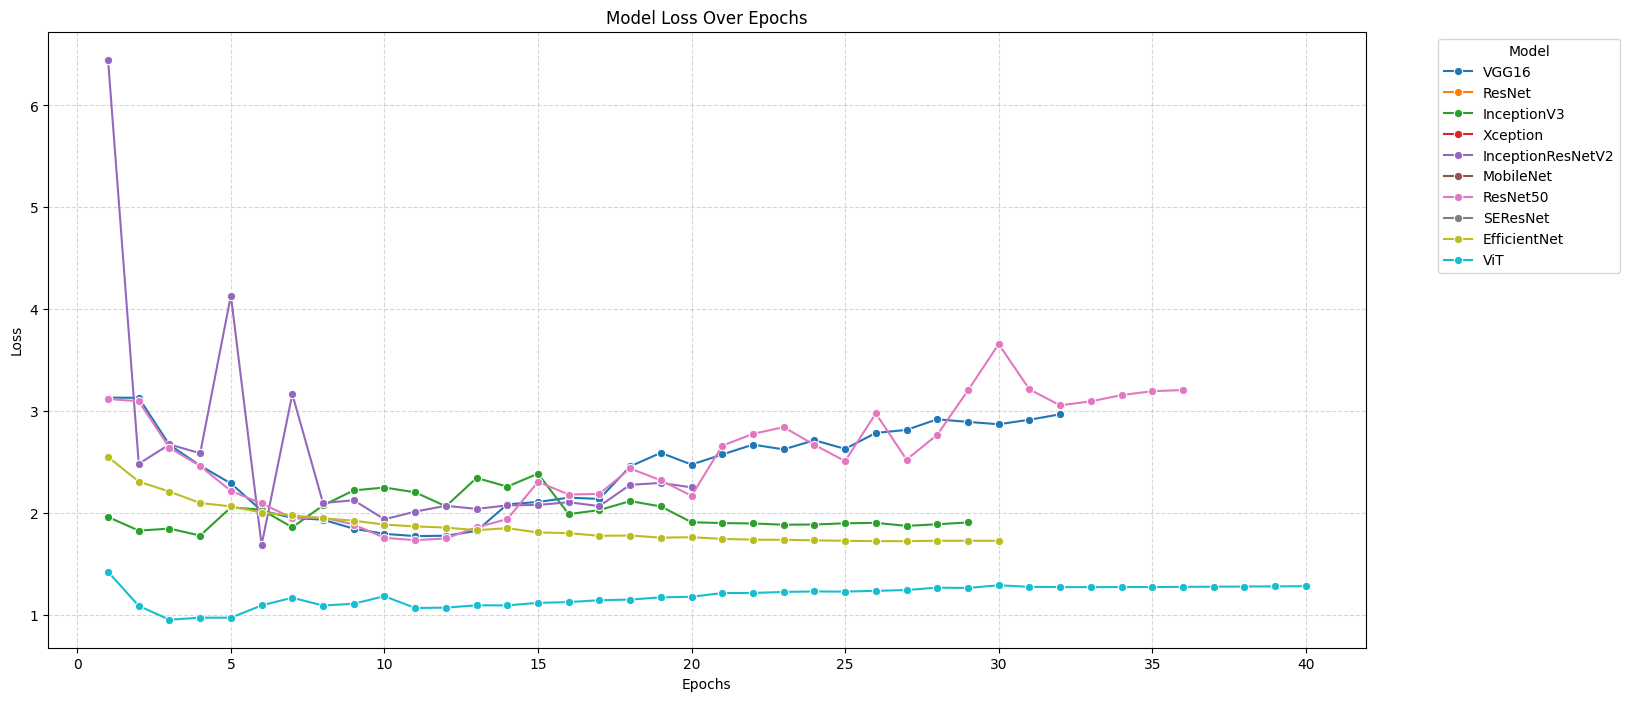

In [175]:
# Plot each metric separately

plot_metrics_seaborn(loss_dict, "Model Loss", "Loss")

## Accuracy

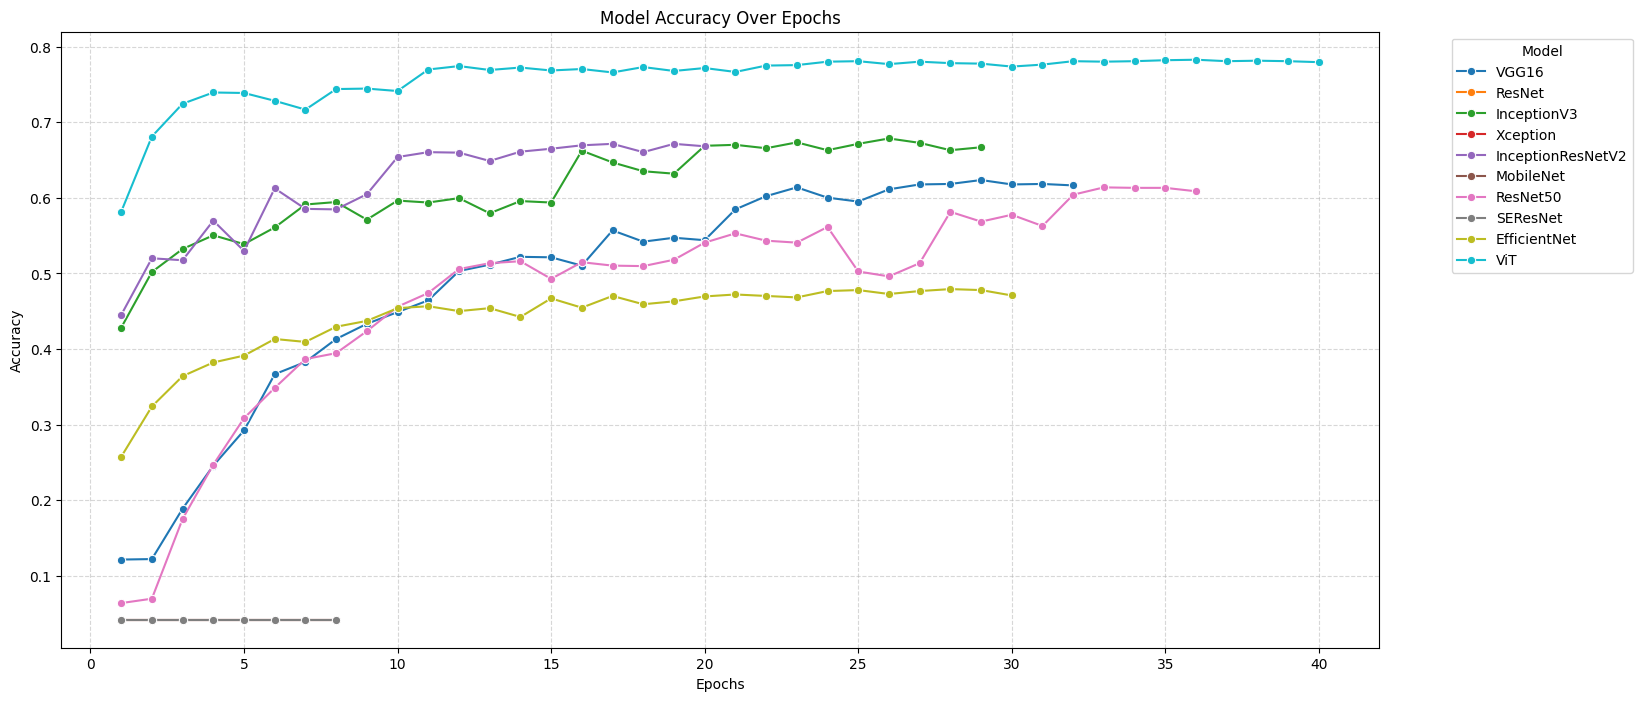

In [172]:
plot_metrics_seaborn(accuracy_dict, "Model Accuracy", "Accuracy")


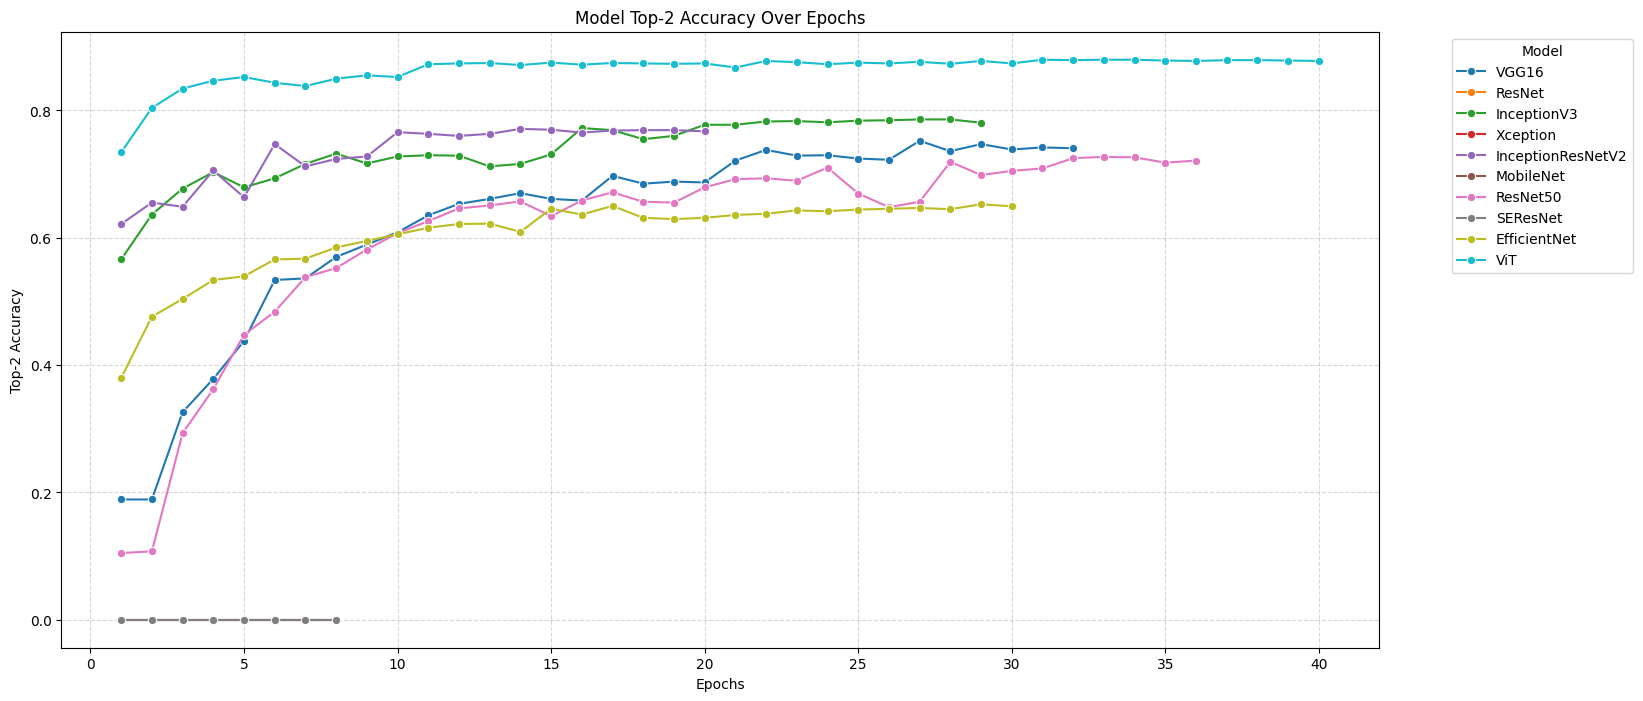

In [173]:
plot_metrics_seaborn(top_2_accuracy_dict, "Model Top-2 Accuracy", "Top-2 Accuracy")